<a href="https://colab.research.google.com/github/CristinaMarsh/Learning_/blob/main/Experiment/Experiment_Pipeline_for_DeepAR_(Compare_with_baseline).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install gluonts
!pip install mxnet-cu101

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.5 MB 5.6 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 360.0 MB 17 kB/s 
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1


https://notebooks.githubusercontent.com/view/ipynb?browser=chrome&color_mode=auto&commit=28541a616924c042e062c2149cd3a7236f20b32b&device=unknown&enc_url=68747470733a2f2f7261772e67697468756275736572636f6e74656e742e636f6d2f6177732d73616d706c65732f616d617a6f6e2d736167656d616b65722d74696d652d7365726965732d70726564696374696f6e2d7573696e672d676c756f6e74732f323835343161363136393234633034326530363263323134396364336137323336663230623332622f6e6f7465626f6f6b732f70617274332f747769747465725f766f6c756d655f666f7265636173742e6970796e62&logged_in=false&nwo=aws-samples%2Famazon-sagemaker-time-series-prediction-using-gluonts&path=notebooks%2Fpart3%2Ftwitter_volume_forecast.ipynb&platform=android&repository_id=224040189&repository_type=Repository&version=99

In [2]:
import mxnet
import gluonts
print(mxnet.__version__)

1.9.1


In [5]:
! pip install boto3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 132 kB 5.1 MB/s 
     |████████████████████████████████| 79 kB 9.7 MB/s 
     |████████████████████████████████| 9.0 MB 38.2 MB/s 
     |████████████████████████████████| 139 kB 62.3 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
requests 2.23.0 requires urllib3!=1.25.0,!=1.25.1,<1.26,>=1.21.1, but you have urllib3 1.26.10 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mxnet import gpu, cpu
from mxnet.context import num_gpus
from gluonts.dataset.util import to_pandas
from gluonts.model.deepar import DeepAREstimator
from gluonts.model.simple_feedforward import SimpleFeedForwardEstimator
from gluonts.dataset.common import ListDataset
from gluonts.mx.trainer import Trainer
from gluonts.evaluation.backtest import make_evaluation_predictions, backtest_metrics
import pathlib
import json
import boto3
import csv

/usr/local/lib/python3.7/dist-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.10) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)
/usr/local/lib/python3.7/dist-packages/gluonts/json.py:102: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  "Using `json`-module for json-handling. "


In [2]:
EPOCHS = 20

In [3]:
url = "https://raw.githubusercontent.com/numenta/NAB/master/data/realTweets/Twitter_volume_AMZN.csv"

df = pd.read_csv(filepath_or_buffer=url, header=0, index_col=0)
df.head()

,value
timestamp,
2015-02-26 21:42:53,57
2015-02-26 21:47:53,43
2015-02-26 21:52:53,55
2015-02-26 21:57:53,64
2015-02-26 22:02:53,93


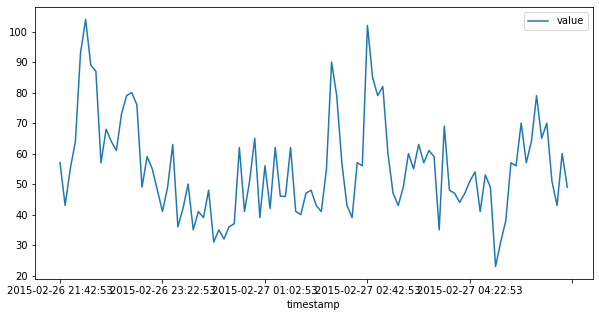

In [4]:
df[:100].plot(figsize=(10,5))

In [5]:
from pylab import rcParams
rcParams['figure.figsize'] = 15, 8
def plot_forecast(predictor, test_data):
    prediction_intervals = (50.0, 90.0)
    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]
    forecast_it, ts_it = make_evaluation_predictions(
        dataset=test_data,  
        predictor=predictor,  
        num_samples=100,  
    )
    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    list(ts_it)[0][-336:].plot(ax=ax)  
    list(forecast_it)[0].plot(prediction_intervals, color='g')
    plt.grid(which="both")
    plt.legend(legend, loc="upper left")
    plt.show()

In [6]:
training_data = ListDataset([{"start": df.index[0], 
                              "target": df.value[: "2015-04-05 00:00:00"]}], 
                              freq="5min")

test_data = ListDataset([{"start": df.index[0], 
                          "target": df.value[:"2015-04-15 00:00:00"]}], 
                          freq="5min")

In [7]:
from gluonts.model.seasonal_naive import *
from gluonts.evaluation import Evaluator

naive_predictor = SeasonalNaivePredictor(freq='5min', 
                                         prediction_length=36,
                                         season_length=300)

In [8]:
forecast_it_baseline, ts_it_baseline = make_evaluation_predictions(test_data, naive_predictor,  num_samples=100)
forecasts_baseline = list(forecast_it_baseline)
tss_baseline = list(ts_it_baseline)
evaluator = Evaluator()
agg_metrics_baseline, item_metrics = evaluator(iter(tss_baseline), iter(forecasts_baseline), num_series=len(test_data))


Running evaluation: 100%|██████████| 1/1 [00:00<00:00, 26.51it/s]


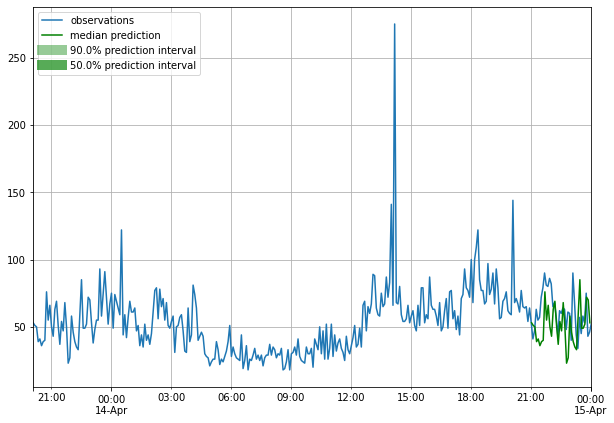

In [9]:
plot_forecast(naive_predictor, test_data)

In [10]:
agg_metrics_baseline

{'Coverage[0.1]': 0.3333333333333333,
 'Coverage[0.2]': 0.3333333333333333,
 'Coverage[0.3]': 0.3333333333333333,
 'Coverage[0.4]': 0.3333333333333333,
 'Coverage[0.5]': 0.3333333333333333,
 'Coverage[0.6]': 0.3333333333333333,
 'Coverage[0.7]': 0.3333333333333333,
 'Coverage[0.8]': 0.3333333333333333,
 'Coverage[0.9]': 0.3333333333333333,
 'MAE_Coverage': 0.25555555555555554,
 'MAPE': 0.30172369215223527,
 'MASE': 0.9703406061648387,
 'MSE': 538.0833333333334,
 'MSIS': 38.81362424659355,
 'ND': 0.3083599817268159,
 'NRMSE': 0.38148855158953615,
 'OWA': nan,
 'QuantileLoss[0.1]': 386.2,
 'QuantileLoss[0.2]': 458.4,
 'QuantileLoss[0.3]': 530.6,
 'QuantileLoss[0.4]': 602.8,
 'QuantileLoss[0.5]': 675.0,
 'QuantileLoss[0.6]': 747.2000000000002,
 'QuantileLoss[0.7]': 819.4,
 'QuantileLoss[0.8]': 891.6,
 'QuantileLoss[0.9]': 963.7999999999998,
 'RMSE': 23.19662331748596,
 'abs_error': 675.0,
 'abs_target_mean': 60.80555555555556,
 'abs_target_sum': 2189.0,
 'mean_absolute_QuantileLoss': 675.

In [14]:
from gluonts.mx.distribution import DistributionOutput, StudentTOutput

deepar_estimator = DeepAREstimator(freq="5min", 
                                   
                                   prediction_length=36,
                                   distr_output=StudentTOutput(),
                                   trainer=Trainer(ctx='gpu',epochs=EPOCHS))

In [15]:
deepar_predictor = deepar_estimator.train(training_data=training_data)

100%|██████████| 50/50 [00:14<00:00,  3.37it/s, epoch=20/20, avg_epoch_loss=3.94]


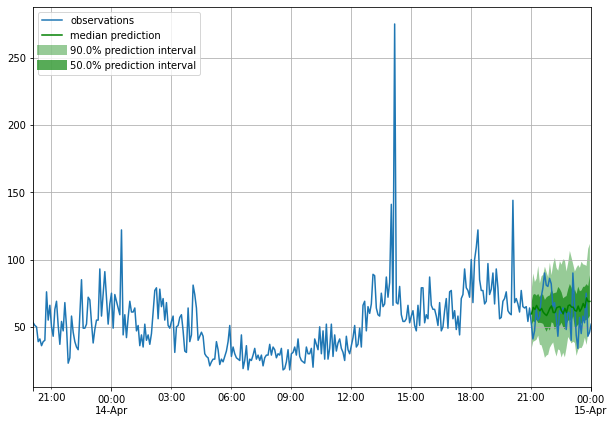

In [16]:
plot_forecast(predictor=deepar_predictor, test_data=test_data)

## Save the model
Both training and prediction networks can be saved using estimator.serialize_prediction_net and estimator.serialize respectively.

In [17]:
import os
os.makedirs('deepar', exist_ok=True)
deepar_predictor.serialize_prediction_net(pathlib.Path('deepar'))
deepar_predictor.serialize(pathlib.Path('deepar'))

## Evaluation
Below we are using gluonts.evaluation.Evaluator to create an aggregated evaluation metrics of the model we have trained. The Evaluator accepts predictions and calculates multiple evaluation metrics such as "MSE" and "Quantile Loss". The Evaluator returns both a dictionary and a pandas DataFrame. You can use the python dictionary, first output, or the pandas DataFrame, the second output, depending on what you would like to do. The dictionary item includes more values.

In [18]:
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.evaluation import Evaluator

forecast_it, ts_it = make_evaluation_predictions(dataset=test_data, 
                                                        predictor=deepar_predictor, 
                                                        num_samples=100)
deepar_agg_metrics, item_metrics = Evaluator(quantiles=[0.1, 0.5, 0.9])(
                                                ts_it, 
                                                forecast_it, 
                                                num_series=len(training_data))
deepar_agg_metrics

Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  1.24it/s]


{'Coverage[0.1]': 0.19444444444444445,
 'Coverage[0.5]': 0.6666666666666666,
 'Coverage[0.9]': 0.9166666666666666,
 'MAE_Coverage': 0.09259259259259256,
 'MAPE': 0.23785008324517143,
 'MASE': 0.6604322841927598,
 'MSE': 255.53564453125,
 'MSIS': 3.91131811105909,
 'ND': 0.20987567230684673,
 'NRMSE': 0.26289509501542374,
 'OWA': nan,
 'QuantileLoss[0.1]': 178.90302352905275,
 'QuantileLoss[0.5]': 459.4178695678711,
 'QuantileLoss[0.9]': 206.58054504394522,
 'RMSE': 15.985482305243405,
 'abs_error': 459.4178466796875,
 'abs_target_mean': 60.80555555555556,
 'abs_target_sum': 2189.0,
 'mean_absolute_QuantileLoss': 281.633812713623,
 'mean_wQuantileLoss': 0.12865866272892784,
 'sMAPE': 0.21041852898067898,
 'seasonal_error': 19.32311178247734,
 'wQuantileLoss[0.1]': 0.08172819713524566,
 'wQuantileLoss[0.5]': 0.20987568276284654,
 'wQuantileLoss[0.9]': 0.09437210828869129}

In [19]:
print(deepar_agg_metrics["MSE"],agg_metrics_baseline["MSE"])

255.53564453125 538.0833333333334


## Baseline: Additional: Comparison with Mulitlayer Perceptron

In [21]:
mlp_estimator = SimpleFeedForwardEstimator(
                                           prediction_length=36, 
                                           trainer=Trainer(epochs=EPOCHS))
mlp_predictor = mlp_estimator.train(training_data=training_data)

100%|██████████| 50/50 [00:00<00:00, 99.90it/s, epoch=20/20, avg_epoch_loss=4.39]


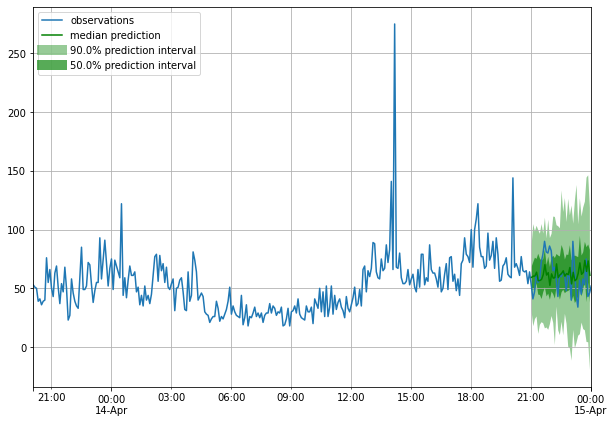

In [22]:
plot_forecast(predictor=mlp_predictor, test_data=test_data)

In [23]:
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.evaluation import Evaluator
def evaluat_models_from_dict(data, predictors, predictor_names, num_samples=100):
    '''
    Comparing results of multiple models.
    Parameters:
        data: the dataset on which we are performing the evaluation.
        predictors: A list of predictor objects
        predictor_names: A list of textual names for the predictors that have an ordered one-to-one
                         relationship with the predictors.
        num_samples (default=100): what sample size from the evaluation dataset.
    Output: pandas dataframe to an evaluation column per predictor.
    '''
    df = pd.DataFrame()
    for (predictor, predictor_name) in zip(predictors, predictor_names):
        forecast_it, ts_it = make_evaluation_predictions(data, 
                                                        predictor=predictor, 
                                                        num_samples=num_samples)
        deepar_agg_metrics, item_metrics = Evaluator(quantiles=[0.1, 0.5, 0.9])(
                                                     ts_it, 
                                                     forecast_it, 
                                                     num_series=len(data))
               
        evaluation = pd.DataFrame.from_dict(deepar_agg_metrics, orient='index', columns=[predictor_name])
        if df.empty:
            df = evaluation.copy()
        else:
            df.insert(loc=len(df.columns), column=predictor_name, value=evaluation.values)
    return df
evaluat_models_from_dict(data=test_data, 
               predictors=[deepar_predictor, mlp_predictor, naive_predictor], 
               predictor_names = ['deepar', 'mlp', 'naive predictor'])

Running evaluation: 100%|██████████| 1/1 [00:00<00:00, 14.69it/s]


,deepar,mlp,naive predictor
MSE,229.416775,241.154894,538.083333
abs_error,430.995758,504.801300,675.000000
abs_target_sum,2189.000000,2189.000000,2189.000000
abs_target_mean,60.805556,60.805556,60.805556
seasonal_error,19.323112,19.323112,19.323112
MASE,0.619574,0.725673,0.970341
MAPE,0.223000,0.255680,0.301724
sMAPE,0.198655,0.230447,0.335600
MSIS,4.104293,7.006594,38.813624
QuantileLoss[0.1],179.346475,238.052280,386.200000


In [25]:
import gluonts


gluonts.model.deepar._network.DeepARTrainingNetwork.__bases__[0].__bases__[0]

mxnet.gluon.block.HybridBlock

In [26]:
deepar_predictor.prediction_net.collect_params() 

deeparpredictionnetwork0_ (
  Parameter deeparpredictionnetwork0_None_distr_mu_weight (shape=(1, 40), dtype=<class 'numpy.float32'>)
  Parameter deeparpredictionnetwork0_None_distr_mu_bias (shape=(1,), dtype=<class 'numpy.float32'>)
  Parameter deeparpredictionnetwork0_None_distr_sigma_weight (shape=(1, 40), dtype=<class 'numpy.float32'>)
  Parameter deeparpredictionnetwork0_None_distr_sigma_bias (shape=(1,), dtype=<class 'numpy.float32'>)
  Parameter deeparpredictionnetwork0_None_distr_nu_weight (shape=(1, 40), dtype=<class 'numpy.float32'>)
  Parameter deeparpredictionnetwork0_None_distr_nu_bias (shape=(1,), dtype=<class 'numpy.float32'>)
  Parameter deeparpredictionnetwork0_lstm0_i2h_weight (shape=(160, 43), dtype=<class 'numpy.float32'>)
  Parameter deeparpredictionnetwork0_lstm0_h2h_weight (shape=(160, 40), dtype=<class 'numpy.float32'>)
  Parameter deeparpredictionnetwork0_lstm0_i2h_bias (shape=(160,), dtype=<class 'numpy.float32'>)
  Parameter deeparpredictionnetwork0_lstm0_h2h_